# Wallmart-Simple EDA

이 노트북에서는 캐글의 Wall Mart TripType 경진대회 데이터를 분석해 볼 것 이다.

주어진 데이터를 분석해 고객의 TripType을 예측하는 것이 목적이지만, 여기서는 간단한 탐사분석을 시행하겠다.

알고 싶은 것들
- 어떤 고객이 물건을 많이 사는가?
- 가장 잘파리는 상품의 Department는?
- 요일과 상품과의 관계
- TripType 조사

In [4]:
% %matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Data fields

TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting.

TripType_999 is an "other" category.

VisitNumber - an id corresponding to a single trip by a single customer

Weekday - the weekday of the trip

Upc - the UPC number of the product purchased

ScanCount - the number of the given item that was purchased. A negative value indicates a product return.

DepartmentDescription - a high-level description of the item's department

FinelineNumber - a more refined category for each of the products, created by Walmart

In [11]:
train = pd.read_csv("train.csv")

In [12]:
#dataset 확인
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [13]:
# train dataset의 정보나열
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


총 647054개의 데이터가 존재한다. Upc,ScanCount,DepartmentDescription,FinelineNumber에 MissingData 존재

In [14]:
train.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,647054.000000,647054.000000,6.429250e+05,647054.000000,642925.000000
mean,58.584511,96167.640078,3.060698e+10,1.108878,3726.884567
std,157.635533,55545.485154,9.120134e+10,0.700776,2780.966158
min,3.000000,5.000000,8.340000e+02,-12.000000,0.000000
25%,27.000000,49268.000000,3.400001e+09,1.000000,1404.000000
50%,39.000000,97074.000000,7.050103e+09,1.000000,3352.000000
75%,40.000000,144316.000000,3.006531e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


ScanCount의 - 는 환불을 의미한다.

## 어떤 고객이 물건을 많이 사는가?

In [23]:
#vistnumber로 groupby로 가장 많이 구매한 TOP 5추출
train.groupby('VisitNumber')['ScanCount'].sum().to_frame().sort_values(by='ScanCount',ascending=False)[0:5]

,ScanCount
VisitNumber,
72439,311
88011,183
9181,137
65792,133
178154,133


In [ ]:
train.groupby('VisitNumber')['ScanCount'].sum().to_frame().sort_values(by='ScanCount',ascending=False)[0:5]

그렇다면 TOP 5는 어떤 Department의 물건을 많아 구매했을까?

In [38]:
train.loc[(train['VisitNumber'] ==72439)|(train['VisitNumber'] ==88011)|(train['VisitNumber'] ==9181)|(train['VisitNumber'] ==65792)|(train['VisitNumber'] ==178154),
          'DepartmentDescription'].value_counts()[0:5]

GROCERY DRY GOODS    144
PERSONAL CARE         59
DSD GROCERY           46
PRODUCE               41
COOK AND DINE         40
Name: DepartmentDescription, dtype: int64

Top5가 구매한 Top5 Department 

주로 실생활 용품과 관련된 물건을 많이 구매한다는 것을 알 수 있다.

## 가장 잘파리는 상품의 Department는?

In [45]:
department = train["DepartmentDescription"].value_counts()[0:10].to_frame().reset_index()

In [103]:
department.head()

,department,count
0,GROCERY DRY GOODS,70402
1,DSD GROCERY,68332
2,PRODUCE,51115
3,DAIRY,43820
4,PERSONAL CARE,41969


In [51]:
department.columns =['department','count']

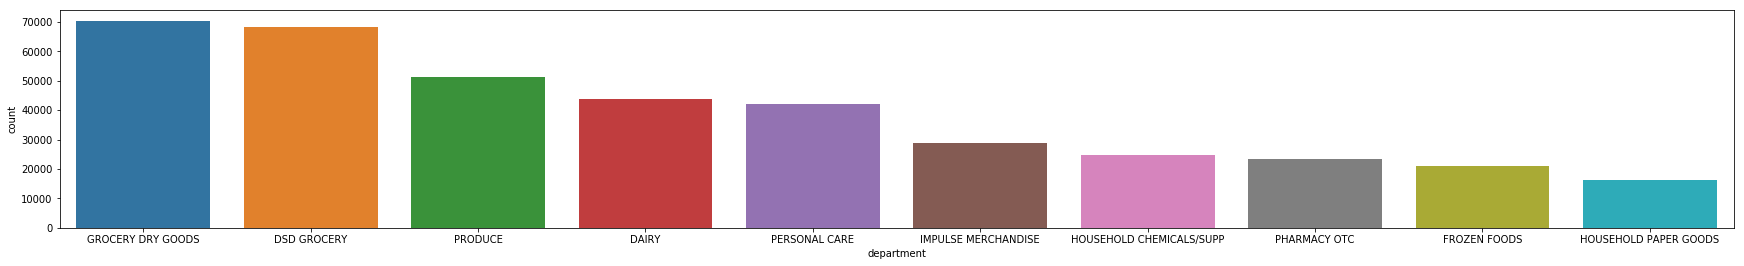

In [58]:
plt.figure(figsize=(30,4))
sns.barplot(data = department, x='department',y='count')

식료품과 같은 데일리 상품과 같은 실생활 용품이 가장 많이 판매된다.

## 요일과 상품과의 관계

가장 고객이 방문한 요일 찾기

In [70]:
# VisitNumber로 grouping 하기 구매를 많이 했더라도 한번 방문한것이 때문
sample = train.groupby(['VisitNumber','Weekday'])['ScanCount'].count().to_frame()

In [80]:
sample.reset_index(inplace=True)

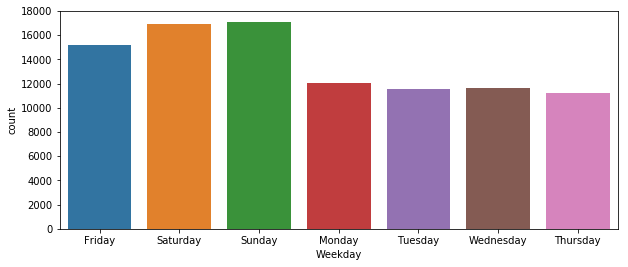

In [84]:
plt.figure(figsize=(10,4))
sns.countplot(sample['Weekday'])

토,일이 주중보다 높은 수치를 보인다. 주중에서는 금요일이 가장 높다.

__________________________

그렇다면 많이 팔리는 Top5 물건들은 무슨 요일에 가장 많이 발릴까?

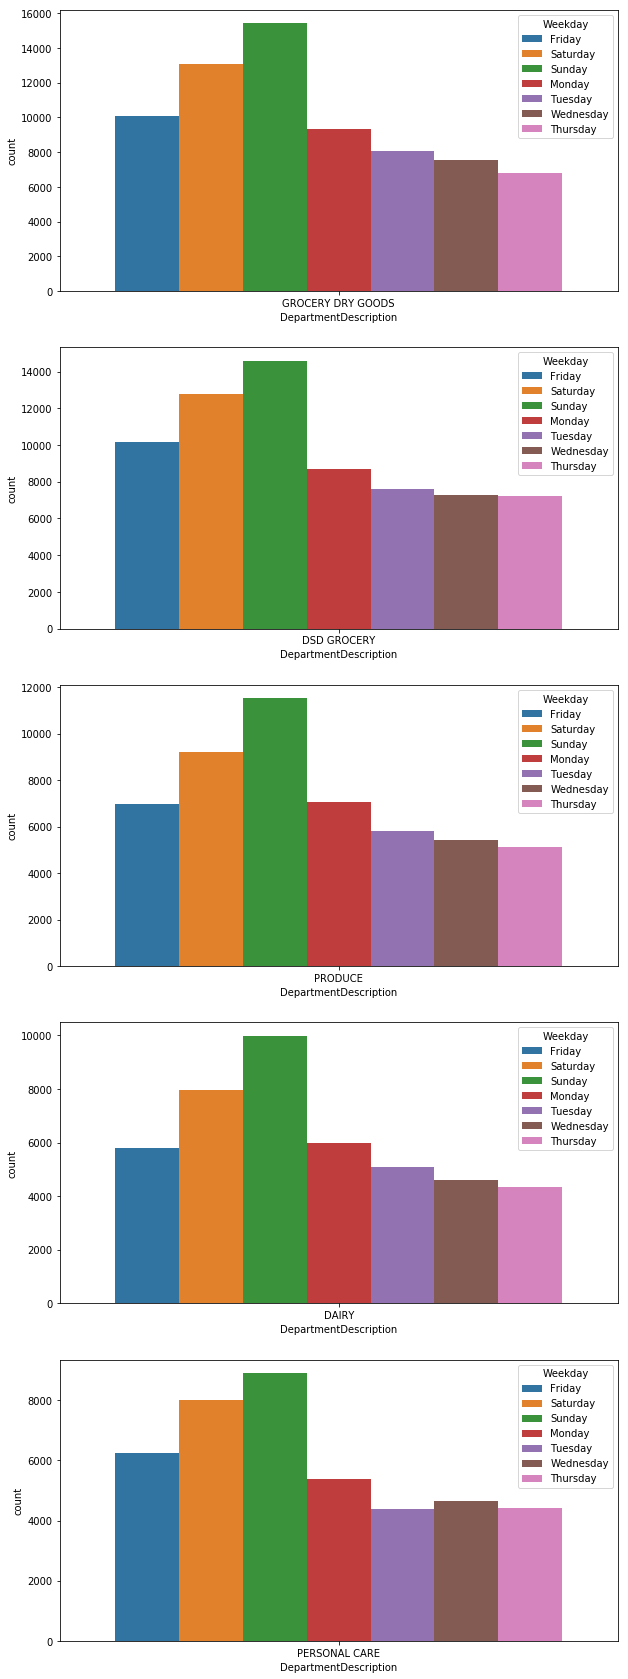

In [112]:
#hue를 이용해 TOp5 Department 요일별 판매량 비교
figure,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5,ncols=1)
figure.set_size_inches(10,30)
sns.countplot(train.loc[train['DepartmentDescription']=='GROCERY DRY GOODS','DepartmentDescription'],hue=train['Weekday'],ax=ax1)
sns.countplot(train.loc[train['DepartmentDescription']=='DSD GROCERY','DepartmentDescription'],hue=train['Weekday'],ax=ax2)
sns.countplot(train.loc[train['DepartmentDescription']=='PRODUCE','DepartmentDescription'],hue=train['Weekday'],ax=ax3)
sns.countplot(train.loc[train['DepartmentDescription']=='DAIRY','DepartmentDescription'],hue=train['Weekday'],ax=ax4)
sns.countplot(train.loc[train['DepartmentDescription']=='PERSONAL CARE','DepartmentDescription'],hue=train['Weekday'],ax=ax5)

Dairy(버터) 빼고는 요일별 구매추세가 동일하다. Dairy의 경우 금요일과 월요일의 구매량이 비슷하다.

In [114]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


## Trip Type 조사

In [125]:
# Trip Type의 가지수 확인
len(train['TripType'].unique())

38

38개의 Type 존재

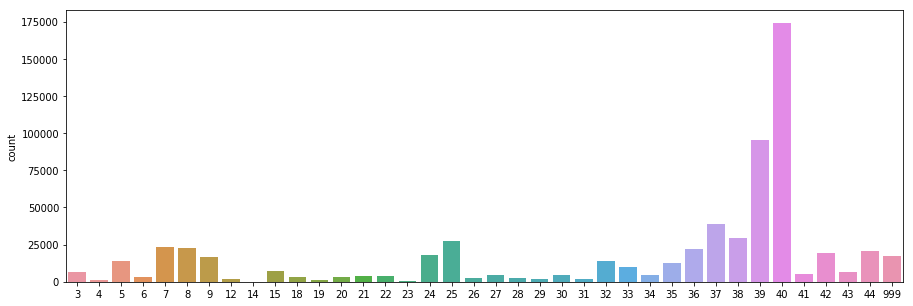

In [131]:
plt.figure(figsize=(15,5))
sns.countplot(train['TripType'])

Type 40과 39가 앞도적으로 많은 것을 확인할 수 있다.

______________________________________________

In [145]:
#type 40일때의 Top5 Department
train.loc[train['TripType']==40,'DepartmentDescription'].value_counts()[0:5]

GROCERY DRY GOODS    32639
DSD GROCERY          22157
DAIRY                17354
PRODUCE              16704
PERSONAL CARE         9911
Name: DepartmentDescription, dtype: int64

In [137]:
#type 39알때의 Top5 Department
train.loc[train['TripType']==39,'DepartmentDescription'].value_counts()[0:5]

DSD GROCERY          12956
GROCERY DRY GOODS    12602
PERSONAL CARE         8126
DAIRY                 6895
PRODUCE               6490
Name: DepartmentDescription, dtype: int64

Type 40과 39일때 Department의 추세는 비슷하다. 39일때는 GDG보다 DSD가 높긴하지만 유의미하다고 판단내리기에는 이르다.

In [140]:
#type 40알때의 Weekday
train.loc[train['TripType']==40,'Weekday'].value_counts()

Sunday       43024
Saturday     36383
Friday       23002
Monday       22380
Tuesday      17954
Wednesday    16748
Thursday     14673
Name: Weekday, dtype: int64

In [139]:
#type 39알때의 Weekday
train.loc[train['TripType']==39,'Weekday'].value_counts()

Sunday       19444
Saturday     16708
Friday       14551
Monday       12884
Tuesday      11005
Thursday     10549
Wednesday    10363
Name: Weekday, dtype: int64

Type 40과 39일때 Weekday 추세는 비슷하다. 39일때 목요일이 수요일보다 높긴 하지만 차이미가 미미하고 유의미하다고 판단하기에는 이르다.